Imports

In [ ]:
!pip install pandasql
!pip install pmdarima
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
from google.colab import drive
import datetime as dt
from datetime import date, timedelta
from pandasql import sqldf
import itertools
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
import math
import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pandasql: filename=pandasql-0.7.3-py3-none-any.whl size=26787 sha256=ca56fa0eb4f0205750976de293e633de5ceb36b8c50120de4c8187720858591c
  Stored in directory: /root/.cache/pip/wheels/ed/8f/46/a383923333728744f01ba24adbd8e364f2cb9470a8b8e5b9ff
Successfully built pandasql
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 15.1 MB/s 
     |████████████████████████████████| 9.9 MB 62.5 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Read Data

In [ ]:
crimeDF = pd.read_csv('/content/drive/MyDrive/NYU Course material/Fall 22/FDS/Project/current_cleaned_data.csv')

Check Info

In [ ]:
crimeDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385373 entries, 0 to 385372
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   CMPLNT_NUM                385373 non-null  int64  
 1   ADDR_PCT_CD               385373 non-null  float64
 2   BORO_NM                   385373 non-null  object 
 3   zipcode                   385373 non-null  int64  
 4   CRM_ATPT_CPTD_CD          385373 non-null  object 
 5   JURISDICTION_CODE         385373 non-null  int64  
 6   JURIS_DESC                385373 non-null  object 
 7   KY_CD                     385373 non-null  int64  
 8   LAW_CAT_CD                385373 non-null  object 
 9   OFNS_DESC                 385373 non-null  object 
 10  PATROL_BORO               385373 non-null  object 
 11  PD_CD                     385373 non-null  float64
 12  PD_DESC                   385373 non-null  object 
 13  PREM_TYP_DESC             385373 non-null  o

Check for nulls

In [ ]:
for col in crimeDF:
  if crimeDF[col].isna().sum():
    print(col,":",crimeDF[col].isna().sum())

Create a column only for dates

In [ ]:
crimeDF['CMPLNT_DT'] = pd.to_datetime(crimeDF['CMPLNT_DT_TS']).dt.date
crimeDF['CMPLNT_DT'] = pd.to_datetime(crimeDF['CMPLNT_DT'])

Find out the first and last date for complaints

In [ ]:
first_date = crimeDF["CMPLNT_DT"].min()
last_date = crimeDF["CMPLNT_DT"].max()
print(first_date,last_date)

2022-01-01 00:00:00 2022-09-30 00:00:00


In [ ]:
day_count = (last_date - first_date).days + 1
day_count

273

In [ ]:
zips = crimeDF.zipcode.unique()

In [ ]:
def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2022, 1, 1)
end_date = date(2022, 10, 1)

In [ ]:
# new = pd.DataFrame(crimeDF.groupby(['zipcode','CMPLNT_DT','LAW_CAT_CD'])['LAW_CAT_CD'].count())
# new = crimeDF[['zipcode','CMPLNT_DT','LAW_CAT_CD']].groupby(['zipcode','LAW_CAT_CD'],as_index = False).count().pivot('zipcode','LAW_CAT_CD').fillna(0)

q = """SELECT zipcode, CMPLNT_DT, LAW_CAT_CD, count(LAW_CAT_CD) as count 
       FROM crimeDF
       group by zipcode, CMPLNT_DT, LAW_CAT_CD;"""

adf = sqldf(q, globals())

In [ ]:
table = pd.pivot_table(adf, values='count', index=['zipcode', 'CMPLNT_DT'],
                    columns=['LAW_CAT_CD'], aggfunc=np.sum).fillna(0).reset_index()

In [ ]:
table['CMPLNT_DT'] = pd.to_datetime(table['CMPLNT_DT'])

In [ ]:
dates = []
for single_date in daterange(start_date, end_date):
    dates.append(single_date.strftime("%Y-%m-%d"))

In [ ]:
zips = pd.DataFrame(zips)
zips.columns = ['zipcode']
dates = pd.DataFrame(dates)
dates.columns = ['CMPLNT_DT']

In [ ]:
zip_date = pd.merge(zips, dates, how ="cross")

In [ ]:
zip_date = zip_date.fillna(0)
zip_date['CMPLNT_DT'] = pd.to_datetime(zip_date['CMPLNT_DT'])

In [ ]:
zip_date.info()
# table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53508 entries, 0 to 53507
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   zipcode    53508 non-null  int64         
 1   CMPLNT_DT  53508 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.2 MB


In [ ]:
# new_df = pd.merge(zip_date, dates,  how='left', left_on=['zipcode','CMPLNT_DT'], right_on=['zipcode','CMPLNT_DT'])
zip_date_countDF = zip_date.merge(table, how='left', on=['zipcode','CMPLNT_DT'])

In [ ]:
zip_date_countDF = zip_date_countDF.fillna(0)

In [ ]:
zip_date_countDF

,zipcode,CMPLNT_DT,FELONY,MISDEMEANOR,VIOLATION
0,10462,2022-01-01,1.0,2.0,0.0
1,10462,2022-01-02,2.0,5.0,1.0
2,10462,2022-01-03,3.0,3.0,2.0
3,10462,2022-01-04,3.0,2.0,2.0
4,10462,2022-01-05,4.0,2.0,6.0
...,...,...,...,...,...
53503,7077,2022-09-26,0.0,0.0,0.0
53504,7077,2022-09-27,0.0,0.0,0.0
53505,7077,2022-09-28,0.0,0.0,0.0
53506,7077,2022-09-29,0.0,0.0,0.0


In [ ]:
def trend(zip):
  df = zip_date_countDF.loc[zip_date_countDF['zipcode'] == zip]
  plt.figure(figsize=(15, 5))
  plt.plot(df["CMPLNT_DT"], df["FELONY"], label = "Felony Trend")
  plt.plot(df["CMPLNT_DT"], df["MISDEMEANOR"], label = "Misdemeanor Trend")
  plt.plot(df["CMPLNT_DT"], df["VIOLATION"], label = "Violation Trend")
  plt.xlabel('Time')
  plt.ylabel('Crime Count')
  plt.title('Crime count vs time')
  plt.legend()

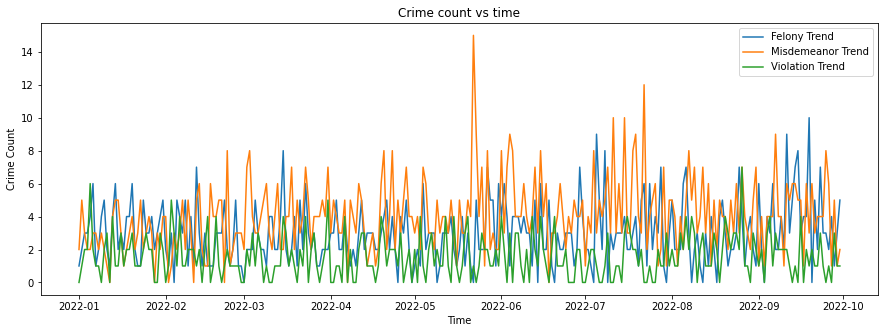

In [ ]:
trend(10462)

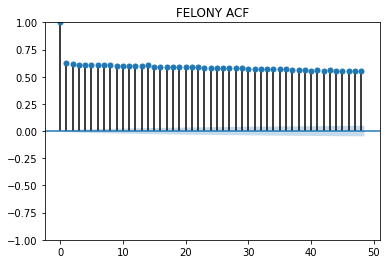

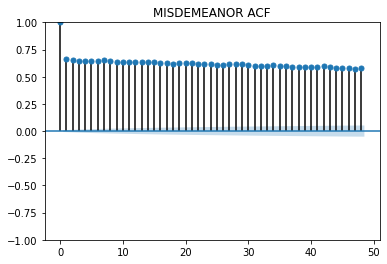

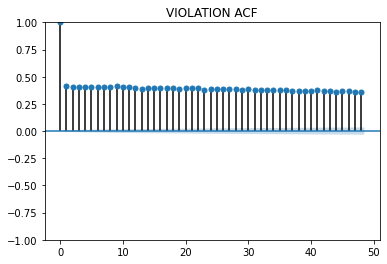

In [ ]:
plot_acf(zip_date_countDF["FELONY"])
plt.title("FELONY ACF")
plt.show()
plot_acf(zip_date_countDF["MISDEMEANOR"])
plt.title("MISDEMEANOR ACF")
plt.show()
plot_acf(zip_date_countDF["VIOLATION"])
plt.title("VIOLATION ACF")
plt.show()

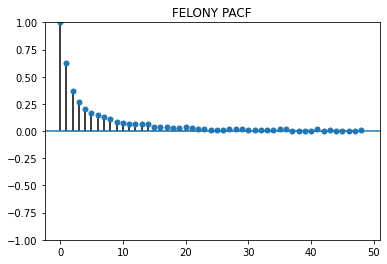

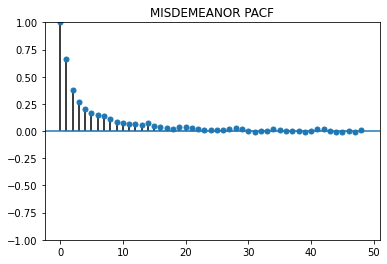

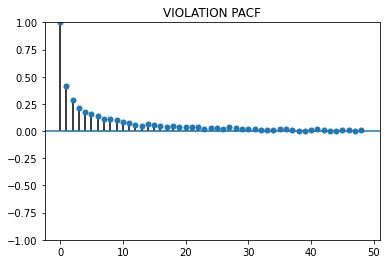

In [ ]:
plot_pacf(zip_date_countDF["FELONY"])
plt.title("FELONY PACF")
plt.show()
plot_pacf(zip_date_countDF["MISDEMEANOR"])
plt.title("MISDEMEANOR PACF")
plt.show()
plot_pacf(zip_date_countDF["VIOLATION"])
plt.title("VIOLATION PACF")
plt.show()

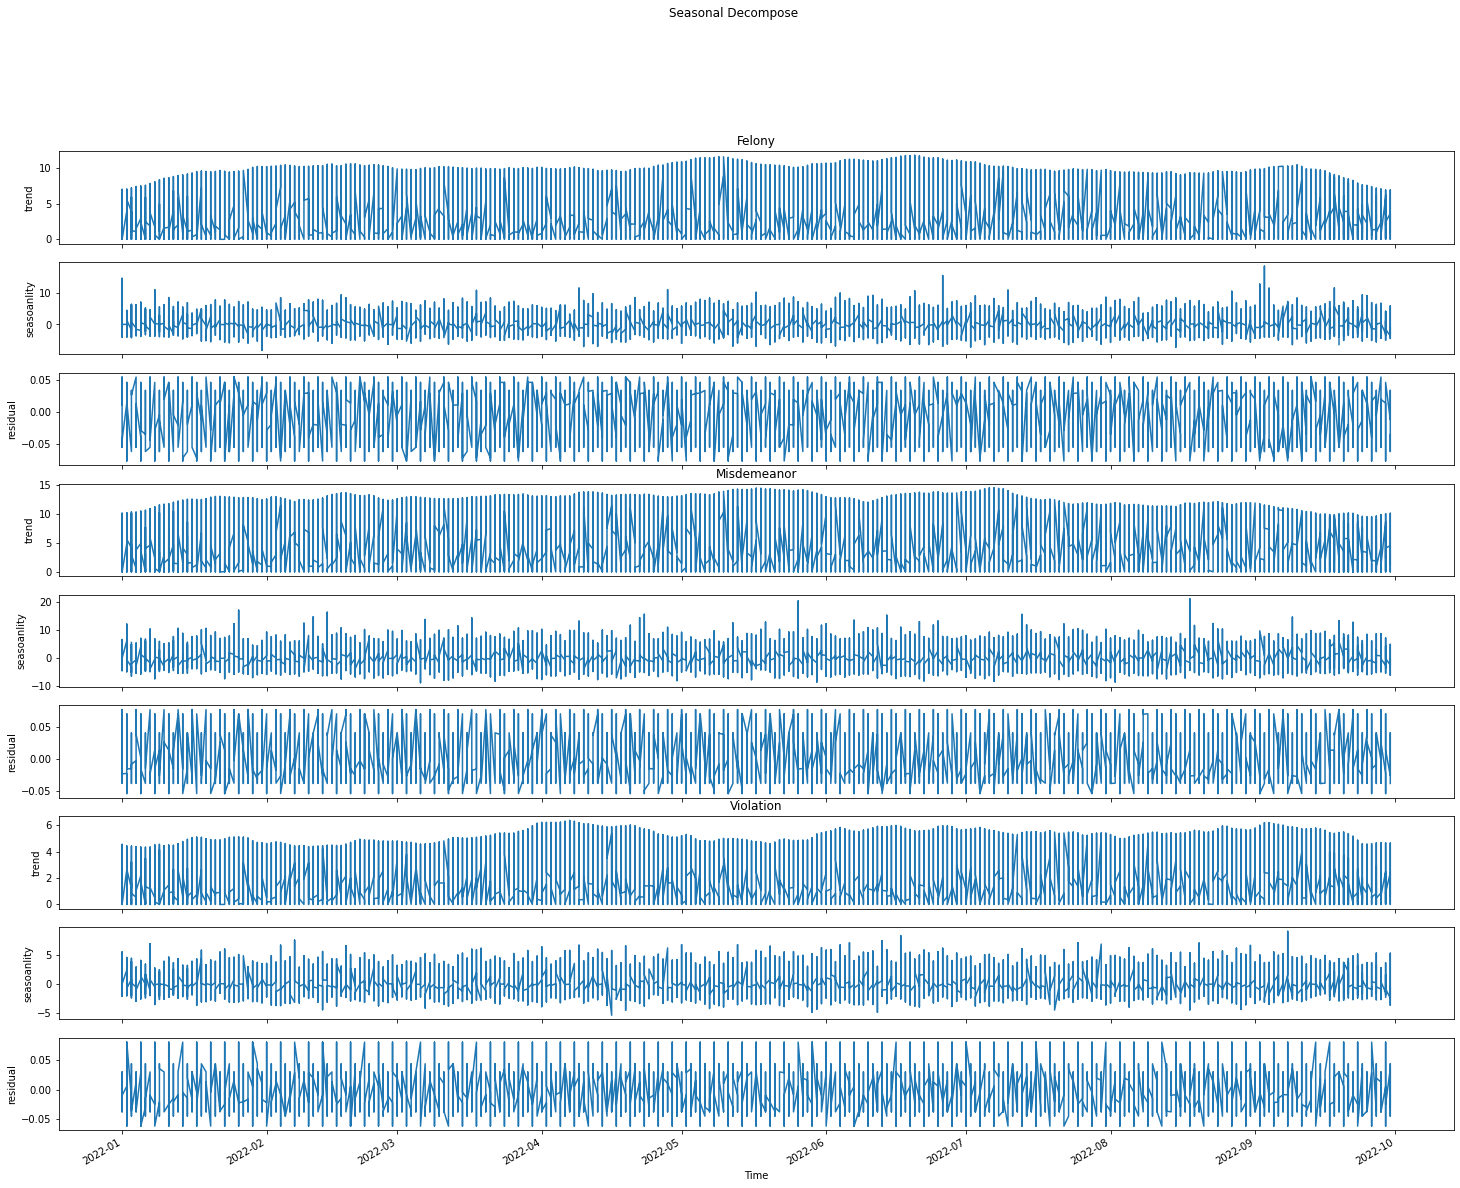

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
df = zip_date_countDF.set_index('CMPLNT_DT')
df_Felony = df["FELONY"]
df_Misdemeanor = df["MISDEMEANOR"]
df_Violation = df["VIOLATION"]

res_Felony = seasonal_decompose(df_Felony, model = "additive",period = 30)
res_Misdemeanor = seasonal_decompose(df_Misdemeanor, model = "additive",period = 30)
res_Violation = seasonal_decompose(df_Violation, model = "additive",period = 30)


fig, axs = plt.subplots(9, figsize=(25,20))
fig.suptitle('Seasonal Decompose')
# Felony
res_Felony.trend.plot(ax=axs[0],ylabel = "trend")
res_Felony.resid.plot(ax=axs[1],ylabel = "seasoanlity")
res_Felony.seasonal.plot(ax=axs[2],ylabel = "residual")
axs[0].set_title('Felony')
# Misdemeanor
res_Misdemeanor.trend.plot(ax=axs[3],ylabel = "trend")
res_Misdemeanor.resid.plot(ax=axs[4],ylabel = "seasoanlity")
res_Misdemeanor.seasonal.plot(ax=axs[5],ylabel = "residual")
axs[3].set_title('Misdemeanor')
# Violation
res_Violation.trend.plot(ax=axs[6],ylabel = "trend")
res_Violation.resid.plot(ax=axs[7],ylabel = "seasoanlity")
res_Violation.seasonal.plot(ax=axs[8],ylabel = "residual")
axs[6].set_title('Violation')

for ax in axs.flat:
  ax.set(xlabel='Time')

for ax in axs.flat:
    ax.label_outer()

In [ ]:
def forecast_pred_ARIMA(zip):
  df = zip_date_countDF.loc[zip_date_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  modelARIMA_Felony = ARIMA(train.FELONY, order=(2,1,0)).fit()
  modelARIMA_Misdemeanor = ARIMA(train.MISDEMEANOR, order=(2,1,0)).fit()
  modelARIMA_Violation = ARIMA(train.VIOLATION, order=(2,1,0)).fit()

  Felony_pred = modelARIMA_Felony.get_forecast(len(test.index))
  Misdemeanor_pred = modelARIMA_Misdemeanor.get_forecast(len(test.index))
  Violation_pred = modelARIMA_Violation.get_forecast(len(test.index))

  Felony_pred_df = Felony_pred.conf_int(alpha = 0.05)
  Misdemeanor_pred_df = Misdemeanor_pred.conf_int(alpha = 0.05)
  Violation_pred_df = Violation_pred.conf_int(alpha = 0.05) 

  Felony_pred_df["Predictions"] = modelARIMA_Felony.predict(start = Felony_pred_df.index[0], end = Felony_pred_df.index[-1])
  Misdemeanor_pred_df["Predictions"] = modelARIMA_Misdemeanor.predict(start = Misdemeanor_pred_df.index[0], end = Misdemeanor_pred_df.index[-1])
  Violation_pred_df["Predictions"] = modelARIMA_Violation.predict(start = Violation_pred_df.index[0], end = Violation_pred_df.index[-1])

  Felony_pred_df.index = test.index
  Misdemeanor_pred_df.index = test.index
  Violation_pred_df.index = test.index

  Felony_pred_out = Felony_pred_df["Predictions"]
  Misdemeanor_pred_out = Misdemeanor_pred_df["Predictions"]
  Violation_pred_out = Violation_pred_df["Predictions"]

  # print("RMSE for Felony: ",np.sqrt(mean_squared_error(test["FELONY"], Felony_pred_out)))
  # print("RMSE for Misdemeanor: ",np.sqrt(mean_squared_error(test["MISDEMEANOR"], Misdemeanor_pred_out)))
  # print("RMSE for Violation: ",np.sqrt(mean_squared_error(test["VIOLATION"], Violation_pred_out)))

  forecast_error_Felony = test["FELONY"] - Felony_pred_out
  forecast_error_Misdemeanor = test["MISDEMEANOR"] - Misdemeanor_pred_out
  forecast_error_Violation = test["VIOLATION"] - Violation_pred_out

  print("RMSE, MFE for Felony = ", str(np.sqrt(mean_squared_error(test["FELONY"], forecast_error_Felony))), str(np.mean(forecast_error_Felony)))
  print("RMSE, MFE for Misdemeanor = ", str(np.sqrt(mean_squared_error(test["MISDEMEANOR"], forecast_error_Misdemeanor))), str(np.mean(forecast_error_Misdemeanor)))
  print("RMSE, MFE for Felony = ", str(np.sqrt(mean_squared_error(test["VIOLATION"], forecast_error_Violation))), str(np.mean(forecast_error_Violation)))

  fig, axs = plt.subplots(3, figsize=(18,14))
  fig.suptitle('ARIMA Model Results')
  # Felony
  axs[0].plot(test['CMPLNT_DT'], test['FELONY'])
  # axs[0].set_title('Actual Felony')
  axs[0].plot(test['CMPLNT_DT'],Felony_pred_out)
  axs[0].set_title('Predicted Felony')
  # Misdemeanor
  axs[1].plot(test['CMPLNT_DT'], test['MISDEMEANOR'])
  # axs[1].set_title('Actual Misdemeanor')
  axs[1].plot(test['CMPLNT_DT'],Misdemeanor_pred_out)
  axs[1].set_title('Predicted Misdemeanor')
  # Violation
  axs[2].plot(test['CMPLNT_DT'], test['VIOLATION'])
  # axs[2].set_title('Actual Violation')
  axs[2].plot(test['CMPLNT_DT'],Violation_pred_out)
  axs[2].set_title('Predicted Violation')

  for ax in axs.flat:
    ax.set(xlabel='Time', ylabel= 'Crime Count')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()

RMSE, MFE for Felony =  1.863369973466734 2.1056517655671128
RMSE, MFE for Misdemeanor =  5.469729890912747 -1.366809473025575
RMSE, MFE for Felony =  1.8953673681348806 -0.3921508125063304


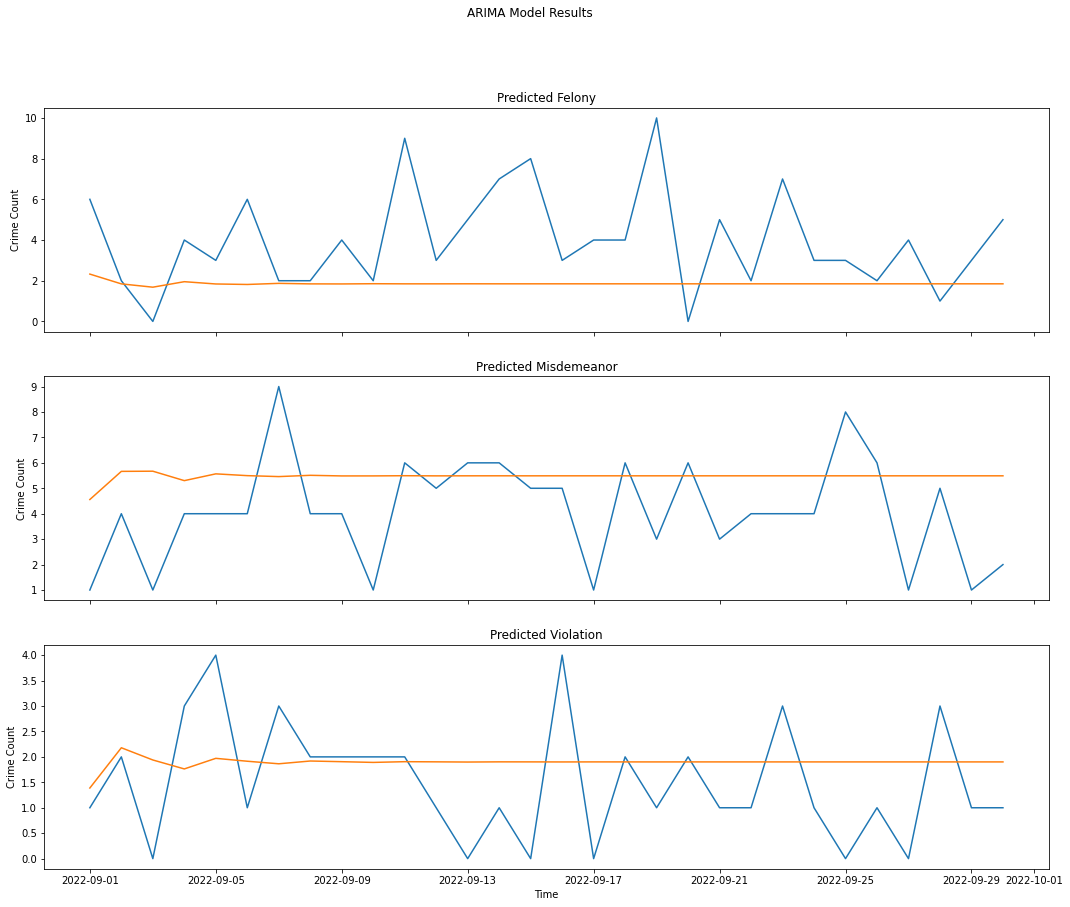

In [ ]:
forecast_pred_ARIMA(10462)

In [ ]:
def forecast_pred_Auto_ARIMA(zip):
  df = zip_date_countDF.loc[zip_date_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  print("test shape = ",test.shape)

  # Felony
  stepwise_model_Felony = auto_arima(df.FELONY, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Felony.fit(train.FELONY)
  future_forecast_Felony = stepwise_model_Felony.predict(n_periods=30)
  # Misdemeanor
  stepwise_model_Misdemeanor = auto_arima(df.MISDEMEANOR, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Misdemeanor.fit(train.MISDEMEANOR)
  future_forecast_Misdemeanor = stepwise_model_Misdemeanor.predict(n_periods=30)
  # Violation
  stepwise_model_Violation = auto_arima(df.VIOLATION, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Violation.fit(train.VIOLATION)
  future_forecast_Violation = stepwise_model_Violation.predict(n_periods=30)

  # print("RMSE for Felony: ",np.sqrt(mean_squared_error(test["FELONY"], future_forecast_Felony)))
  # print("RMSE for Misdemeanor: ",np.sqrt(mean_squared_error(test["MISDEMEANOR"], future_forecast_Misdemeanor)))
  # print("RMSE for Violation: ",np.sqrt(mean_squared_error(test["VIOLATION"], future_forecast_Violation)))
  forecast_error_Felony = test["FELONY"] - future_forecast_Felony
  forecast_error_Misdemeanor = test["MISDEMEANOR"] - future_forecast_Misdemeanor
  forecast_error_Violation = test["VIOLATION"] - future_forecast_Violation

  print("RMSE, MFE for Felony = ", str(np.sqrt(mean_squared_error(test["FELONY"], future_forecast_Felony))), str(np.mean(forecast_error_Felony)))
  print("RMSE, MFE for Misdemeanor = ", str(np.sqrt(mean_squared_error(test["MISDEMEANOR"], future_forecast_Misdemeanor))), str(np.mean(forecast_error_Misdemeanor)))
  print("RMSE, MFE for Violation = ", str(np.sqrt(mean_squared_error(test["VIOLATION"], future_forecast_Violation))), str(np.mean(forecast_error_Violation)))

  fig, axs = plt.subplots(3, figsize=(20,14))
  fig.suptitle('Auto ARIMA Model Results')
  # Felony
  axs[0].plot(test['CMPLNT_DT'], test['FELONY'])
  # axs[0].set_title('Actual Felony')
  axs[0].plot(test['CMPLNT_DT'],future_forecast_Felony)
  ttle_Felony = 'Predicted Felony with RMSE = '+str(np.sqrt(mean_squared_error(test["FELONY"], future_forecast_Felony)))
  axs[0].set_title('Felony')
  axs[0].legend(['actual','predicted'])
  # Misdemeanor
  axs[1].plot(test['CMPLNT_DT'], test['FELONY'])
  # axs[1].set_title('Actual Misdemeanor')
  axs[1].plot(test['CMPLNT_DT'],future_forecast_Misdemeanor)
  ttle_Misdemeanor = 'Predicted Misdemeanor with RMSE = '+str(np.sqrt(mean_squared_error(test["MISDEMEANOR"], future_forecast_Felony)))
  axs[1].set_title('Misdemeanor')
  axs[1].legend(['actual','predicted'])
  # Violation
  axs[2].plot(test['CMPLNT_DT'], test['VIOLATION'])
  # axs[2].set_title('Actual Violation')
  axs[2].plot(test['CMPLNT_DT'],future_forecast_Violation)
  ttle_Violation = 'Predicted Violation with RMSE = '+str(np.sqrt(mean_squared_error(test["VIOLATION"], future_forecast_Violation)))
  axs[2].set_title('Violation')
  axs[2].legend(['actual','predicted'])

  for ax in axs.flat:
    ax.set(xlabel='Time', ylabel= 'Crime Count')

  # Hide x labels and tick labels for top plots and y ticks for right plots.
  for ax in axs.flat:
      ax.label_outer()

test shape =  (30, 5)
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.40 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1445.138, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1319.619, Time=0.44 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.35 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1383.778, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1265.139, Time=0.47 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.41 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1343.954, Time=0.27 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1236.512, Time=0.78 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=1283.386, Time=0.22 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=5.14 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.58 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=1211.784, Time=0.91 sec
 ARIMA(3,1,0)(1,1,0)[12]   

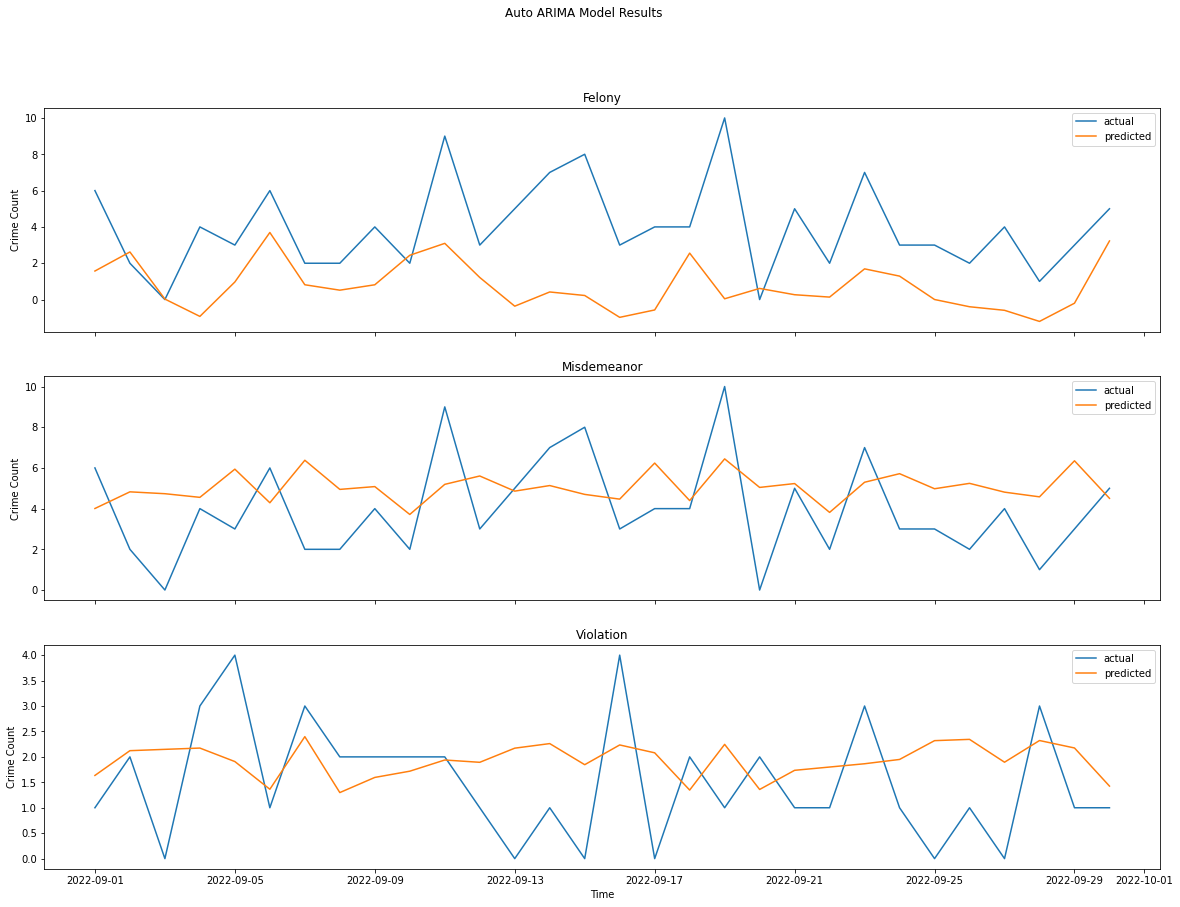

In [ ]:
forecast_pred_Auto_ARIMA(10462)

In [ ]:
crimeDF['VIC_RACE'].value_counts()

UNKNOWN                           117733
BLACK                              95752
WHITE HISPANIC                     67178
WHITE                              56192
ASIAN / PACIFIC ISLANDER           30889
BLACK HISPANIC                     16102
AMERICAN INDIAN/ALASKAN NATIVE      1527
Name: VIC_RACE, dtype: int64

In [ ]:
crimeDF['SUSP_RACE'].value_counts()

Unknown                           164998
BLACK                             114030
WHITE HISPANIC                     50160
WHITE                              28170
BLACK HISPANIC                     16236
ASIAN / PACIFIC ISLANDER           11088
AMERICAN INDIAN/ALASKAN NATIVE       691
Name: SUSP_RACE, dtype: int64

In [ ]:
# New categories

In [ ]:
# pdf_types = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_types.csv'))['types']
# pdf = pd.read_csv(os.path.join(cur_dir, data_dir, 'current_category_cleaned_data.csv'), dtype=pdf_types.to_dict(), parse_dates = ['RPT_DT', 'CMPLNT_DT_TS'])
pdf_types = pd.read_csv(os.path.join('current_category_cleaned_types.csv'))['types']
pdf = pd.read_csv(os.path.join('current_category_cleaned_data.csv'), dtype=pdf_types.to_dict(), parse_dates = ['RPT_DT', 'CMPLNT_DT_TS'])

In [ ]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385373 entries, 0 to 385372
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CMPLNT_NUM                385373 non-null  object        
 1   ADDR_PCT_CD               385373 non-null  float64       
 2   BORO_NM                   385373 non-null  object        
 3   zipcode                   385373 non-null  int64         
 4   CRM_ATPT_CPTD_CD          385373 non-null  object        
 5   JURISDICTION_CODE         385373 non-null  int64         
 6   JURIS_DESC                385373 non-null  object        
 7   KY_CD                     385373 non-null  int64         
 8   LAW_CAT_CD                385373 non-null  object        
 9   OFNS_DESC                 385373 non-null  object        
 10  PATROL_BORO               385373 non-null  object        
 11  PD_CD                     385373 non-null  float64       
 12  PD

In [ ]:
pdf['CMPLNT_DT'] = pd.to_datetime(pdf['CMPLNT_DT_TS']).dt.date
pdf['CMPLNT_DT'] = pd.to_datetime(pdf['CMPLNT_DT'])

In [ ]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385373 entries, 0 to 385372
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   CMPLNT_NUM                385373 non-null  object        
 1   ADDR_PCT_CD               385373 non-null  float64       
 2   BORO_NM                   385373 non-null  object        
 3   zipcode                   385373 non-null  int64         
 4   CRM_ATPT_CPTD_CD          385373 non-null  object        
 5   JURISDICTION_CODE         385373 non-null  int64         
 6   JURIS_DESC                385373 non-null  object        
 7   KY_CD                     385373 non-null  int64         
 8   LAW_CAT_CD                385373 non-null  object        
 9   OFNS_DESC                 385373 non-null  object        
 10  PATROL_BORO               385373 non-null  object        
 11  PD_CD                     385373 non-null  float64       
 12  PD

In [ ]:
q1 = """SELECT zipcode, CMPLNT_DT, OffenseCategory, count(OffenseCategory) as cat_count 
       FROM pdf
       group by zipcode, CMPLNT_DT, OffenseCategory;"""

adf1 = sqldf(q1, globals())

In [ ]:
adf1['OffenseCategory'].value_counts()

Other        42321
Category4    40828
Category1    10597
Category3    10415
Category2     4821
Name: OffenseCategory, dtype: int64

In [ ]:
table1 = pd.pivot_table(adf1, values='cat_count', index=['zipcode', 'CMPLNT_DT'], columns=['OffenseCategory'], aggfunc=np.sum).fillna(0).reset_index()

In [ ]:
table1

OffenseCategory,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,7002,2022-01-16 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
1,7002,2022-01-20 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
2,7002,2022-03-16 00:00:00.000000,0.0,0.0,0.0,0.0,2.0
3,7002,2022-05-02 00:00:00.000000,0.0,0.0,0.0,1.0,0.0
4,7002,2022-05-30 00:00:00.000000,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
46651,11697,2022-07-13 00:00:00.000000,0.0,0.0,0.0,1.0,2.0
46652,11697,2022-07-16 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
46653,11697,2022-07-21 00:00:00.000000,0.0,0.0,0.0,0.0,1.0
46654,11697,2022-07-25 00:00:00.000000,0.0,0.0,1.0,0.0,0.0


In [ ]:
table1['CMPLNT_DT'] = pd.to_datetime(table1['CMPLNT_DT'])

In [ ]:
table1

OffenseCategory,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,7002,2022-01-16,0.0,0.0,0.0,0.0,1.0
1,7002,2022-01-20,0.0,0.0,0.0,0.0,1.0
2,7002,2022-03-16,0.0,0.0,0.0,0.0,2.0
3,7002,2022-05-02,0.0,0.0,0.0,1.0,0.0
4,7002,2022-05-30,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...
46651,11697,2022-07-13,0.0,0.0,0.0,1.0,2.0
46652,11697,2022-07-16,0.0,0.0,0.0,0.0,1.0
46653,11697,2022-07-21,0.0,0.0,0.0,0.0,1.0
46654,11697,2022-07-25,0.0,0.0,1.0,0.0,0.0


In [ ]:
# new_df = pd.merge(zip_date, dates,  how='left', left_on=['zipcode','CMPLNT_DT'], right_on=['zipcode','CMPLNT_DT'])
zip_date_cat_countDF = zip_date.merge(table1, how='left', on=['zipcode','CMPLNT_DT'])

In [ ]:
zip_date_cat_countDF = zip_date_cat_countDF.fillna(0)

In [ ]:
zip_date_cat_countDF

,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
0,10462,2022-01-01,0.0,0.0,0.0,1.0,2.0
1,10462,2022-01-02,0.0,0.0,0.0,1.0,7.0
2,10462,2022-01-03,0.0,0.0,0.0,4.0,4.0
3,10462,2022-01-04,0.0,0.0,0.0,2.0,5.0
4,10462,2022-01-05,0.0,0.0,0.0,4.0,8.0
...,...,...,...,...,...,...,...
53503,7077,2022-09-26,0.0,0.0,0.0,0.0,0.0
53504,7077,2022-09-27,0.0,0.0,0.0,0.0,0.0
53505,7077,2022-09-28,0.0,0.0,0.0,0.0,0.0
53506,7077,2022-09-29,0.0,0.0,0.0,0.0,0.0


In [ ]:
dft = zip_date_cat_countDF.loc[zip_date_cat_countDF['Category1'] == 5]

In [ ]:
dft

,zipcode,CMPLNT_DT,Category1,Category2,Category3,Category4,Other
554,10457,2022-01-09,5.0,0.0,0.0,1.0,13.0
563,10457,2022-01-18,5.0,0.0,2.0,5.0,15.0
566,10457,2022-01-21,5.0,0.0,1.0,4.0,3.0
567,10457,2022-01-22,5.0,0.0,1.0,5.0,5.0
582,10457,2022-02-06,5.0,0.0,3.0,3.0,13.0
...,...,...,...,...,...,...,...
43588,11418,2022-07-01,5.0,0.0,0.0,1.0,2.0
43590,11418,2022-07-03,5.0,0.0,0.0,0.0,1.0
43596,11418,2022-07-09,5.0,0.0,0.0,0.0,5.0
43673,11418,2022-09-24,5.0,0.0,0.0,1.0,1.0


In [ ]:
def forecast_pred_ARIMA_new(zip):
  df = zip_date_cat_countDF.loc[zip_date_cat_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  modelARIMA_Category1 = ARIMA(train.Category1, order=(2,1,0)).fit()
  modelARIMA_Category2 = ARIMA(train.Category2, order=(2,1,0)).fit()
  modelARIMA_Category3 = ARIMA(train.Category3, order=(2,1,0)).fit()
  modelARIMA_Category4 = ARIMA(train.Category4, order=(2,1,0)).fit()

  Category1_pred = modelARIMA_Category1.get_forecast(len(test.index))
  Category2_pred = modelARIMA_Category2.get_forecast(len(test.index))
  Category3_pred = modelARIMA_Category3.get_forecast(len(test.index))
  Category4_pred = modelARIMA_Category4.get_forecast(len(test.index))

  Category1_pred_df = Category1_pred.conf_int(alpha = 0.05)
  Category2_pred_df = Category2_pred.conf_int(alpha = 0.05)
  Category3_pred_df = Category3_pred.conf_int(alpha = 0.05) 
  Category4_pred_df = Category4_pred.conf_int(alpha = 0.05) 

  Category1_pred_df["Predictions"] = modelARIMA_Category1.predict(start = Category1_pred_df.index[0], end = Category1_pred_df.index[-1])
  Category2_pred_df["Predictions"] = modelARIMA_Category2.predict(start = Category2_pred_df.index[0], end = Category2_pred_df.index[-1])
  Category3_pred_df["Predictions"] = modelARIMA_Category3.predict(start = Category3_pred_df.index[0], end = Category3_pred_df.index[-1])
  Category4_pred_df["Predictions"] = modelARIMA_Category4.predict(start = Category4_pred_df.index[0], end = Category4_pred_df.index[-1])

  Category1_pred_df.index = test.index
  Category2_pred_df.index = test.index
  Category3_pred_df.index = test.index
  Category4_pred_df.index = test.index

  Category1_pred_out = Category1_pred_df["Predictions"]
  Category2_pred_out = Category2_pred_df["Predictions"]
  Category3_pred_out = Category3_pred_df["Predictions"]
  Category4_pred_out = Category4_pred_df["Predictions"]

  # forecast_error_Category1 = test["Category1"] - Category1_pred_out
  # forecast_error_Category2 = test["Category2"] - Category2_pred_out
  # forecast_error_Category3 = test["Category3"] - Category3_pred_out
  # forecast_error_Category4 = test["Category4"] - Category4_pred_out

  # print("RMSE, MFE for Category1 = ", str(np.sqrt(mean_squared_error(test["Category1"], forecast_error_Category1))), str(np.mean(forecast_error_Category1)))
  # print("RMSE, MFE for Category2 = ", str(np.sqrt(mean_squared_error(test["Category2"], forecast_error_Category2))), str(np.mean(forecast_error_Category2)))
  # print("RMSE, MFE for Category3 = ", str(np.sqrt(mean_squared_error(test["Category3"], forecast_error_Category3))), str(np.mean(forecast_error_Category3)))
  # print("RMSE, MFE for Category4 = ", str(np.sqrt(mean_squared_error(test["Category4"], forecast_error_Category4))), str(np.mean(forecast_error_Category4)))

  # fig, axs = plt.subplots(4, figsize=(18,14))
  # fig.suptitle('ARIMA Model Results')
  # # Category1
  # axs[0].plot(test['CMPLNT_DT'], test['Category1'])
  # axs[0].plot(test['CMPLNT_DT'],Category1_pred_out)
  # axs[0].set_title('Predicted Category1')
  # # Category2
  # axs[1].plot(test['CMPLNT_DT'], test['Category2'])
  # axs[1].plot(test['CMPLNT_DT'],Category2_pred_out)
  # axs[1].set_title('Predicted Category2')
  # # Category3
  # axs[2].plot(test['CMPLNT_DT'], test['Category3'])
  # axs[2].plot(test['CMPLNT_DT'],Category3_pred_out)
  # axs[2].set_title('Predicted Category3')
  # # Category4
  # axs[3].plot(test['CMPLNT_DT'], test['Category4'])
  # axs[3].plot(test['CMPLNT_DT'],Category4_pred_out)
  # axs[3].set_title('Predicted Category4')

  # for ax in axs.flat:
  #   ax.set(xlabel='Time', ylabel= 'Crime Count')

  # # Hide x labels and tick labels for top plots and y ticks for right plots.
  # for ax in axs.flat:
  #     ax.label_outer()

  return np.array(Category1_pred_out), np.array(Category2_pred_out), np.array(Category3_pred_out), np.array(Category4_pred_out)

In [ ]:
cat1_pred, cat2_pred, cat3_pred, cat4_pred = forecast_pred_ARIMA_new(11418)

In [ ]:
def forecast_pred_Auto_ARIMA_new(zip):
  df = zip_date_cat_countDF.loc[zip_date_cat_countDF['zipcode'] == zip]
  train = df[df.CMPLNT_DT < pd.to_datetime("2022-09-01", format='%Y-%m-%d')]
  test = df[df.CMPLNT_DT >= pd.to_datetime("2022-09-01", format='%Y-%m-%d')]

  # print("test shape = ",test.shape)

  # Category1
  stepwise_model_Category1 = auto_arima(df.Category1, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category1.fit(train.Category1)
  future_forecast_Category1 = stepwise_model_Category1.predict(n_periods=30)
  # Category2
  stepwise_model_Category2 = auto_arima(df.Category2, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category2.fit(train.Category2)
  future_forecast_Category2 = stepwise_model_Category2.predict(n_periods=30)
  # Category3
  stepwise_model_Category3 = auto_arima(df.Category3, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category3.fit(train.Category3)
  future_forecast_Category3 = stepwise_model_Category3.predict(n_periods=30)
  # Category4
  stepwise_model_Category4 = auto_arima(df.Category4, start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
  stepwise_model_Category4.fit(train.Category4)
  future_forecast_Category4 = stepwise_model_Category4.predict(n_periods=30)


# Uncomment for graphs
  # forecast_error_Category1 = test["Category1"] - future_forecast_Category1
  # forecast_error_Category2 = test["Category2"] - future_forecast_Category2
  # forecast_error_Category3 = test["Category3"] - future_forecast_Category3
  # forecast_error_Category4 = test["Category4"] - future_forecast_Category4

  # print("RMSE, MFE for Category1 = ", str(np.sqrt(mean_squared_error(test["Category1"], future_forecast_Category1))), str(np.mean(forecast_error_Category1)))
  # print("RMSE, MFE for Category2 = ", str(np.sqrt(mean_squared_error(test["Category2"], future_forecast_Category2))), str(np.mean(forecast_error_Category2)))
  # print("RMSE, MFE for Category3 = ", str(np.sqrt(mean_squared_error(test["Category3"], future_forecast_Category3))), str(np.mean(forecast_error_Category3)))
  # print("RMSE, MFE for Category4 = ", str(np.sqrt(mean_squared_error(test["Category4"], future_forecast_Category4))), str(np.mean(forecast_error_Category4)))

  # fig, axs = plt.subplots(4, figsize=(20,14))
  # fig.suptitle('Auto ARIMA Model Results')
  # # Category1
  # axs[0].plot(test['CMPLNT_DT'], test['Category1'])
  # # axs[0].set_title('Actual Felony')
  # axs[0].plot(test['CMPLNT_DT'],future_forecast_Category1)
  # ttle_Felony = 'Predicted Category1 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category1"], future_forecast_Category1)))
  # axs[0].set_title('Category1')
  # axs[0].legend(['actual','predicted'])
  # # Category2
  # axs[1].plot(test['CMPLNT_DT'], test['Category2'])
  # # axs[1].set_title('Actual Misdemeanor')
  # axs[1].plot(test['CMPLNT_DT'],future_forecast_Category2)
  # ttle_Misdemeanor = 'Predicted Category2 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category2"], future_forecast_Category2)))
  # axs[1].set_title('Category2')
  # axs[1].legend(['actual','predicted'])
  # # Category3
  # axs[2].plot(test['CMPLNT_DT'], test['Category3'])
  # # axs[2].set_title('Actual Violation')
  # axs[2].plot(test['CMPLNT_DT'],future_forecast_Category3)
  # ttle_Violation = 'Predicted Category3 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category3"], future_forecast_Category3)))
  # axs[2].set_title('Category3')
  # axs[2].legend(['actual','predicted'])
  # # Category4
  # axs[3].plot(test['CMPLNT_DT'], test['Category4'])
  # # axs[2].set_title('Actual Violation')
  # axs[3].plot(test['CMPLNT_DT'],future_forecast_Category4)
  # ttle_Violation = 'Predicted Category4 with RMSE = '+str(np.sqrt(mean_squared_error(test["Category4"], future_forecast_Category4)))
  # axs[3].set_title('Category4')
  # axs[3].legend(['actual','predicted'])

  # for ax in axs.flat:
  #   ax.set(xlabel='Time', ylabel= 'Crime Count')

  # # Hide x labels and tick labels for top plots and y ticks for right plots.
  # for ax in axs.flat:
  #     ax.label_outer()

  return np.array(future_forecast_Category1),np.array(future_forecast_Category2),np.array(future_forecast_Category3),np.array(future_forecast_Category4)

test shape =  (30, 7)
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-5782.317, Time=0.04 sec
Total fit time: 0.041 seconds
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=1.25 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-59.853, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-201.882, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-132.364, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-235.573, Time=0.54 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=3.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-163.061, Time=0.47 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-263.963, Time=1.76 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-230.272, Time=0.41 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=4.38 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=1.55 se

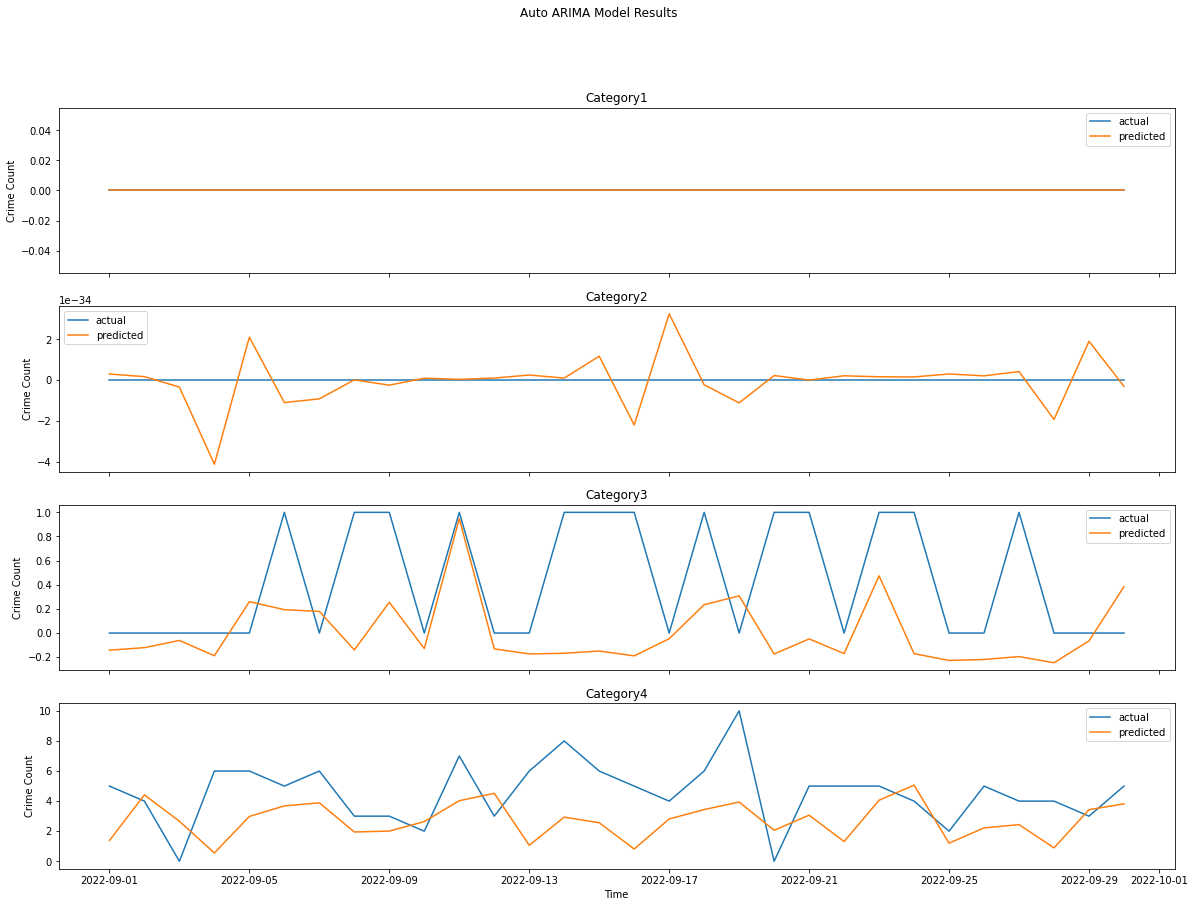

In [ ]:
cat1_pred_AA,cat2_pred_AA,cat3_pred_AA,cat4_pred_AA = forecast_pred_Auto_ARIMA_new(10462)

In [ ]:
cat1_pred_AA

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
def zip_arima_pred():
  zipcode_list = np.array(zips['zipcode'])
  zip_pred_dict = {}
  i = 0
  for zip in zipcode_list:
    # uncomment to track progress
    # print("i = ",i)
    # i+=1
    cat1_pred, cat2_pred, cat3_pred, cat4_pred = forecast_pred_ARIMA_new(zip)
    zip_pred_dict[zip] = [cat1_pred, cat2_pred, cat3_pred, cat4_pred]
  return zip_pred_dict

In [ ]:
predictions_ARIMA_dict = zip_arima_pred()

In [ ]:
# predictions_ARIMA_dict[10462]

In [ ]:
df_arima_pred = pd.DataFrame.from_dict(predictions_ARIMA_dict,orient='index')

In [ ]:
df_arima_pred.reset_index(inplace=True)

In [ ]:
df_arima_pred.columns = ['zipcode','Category1', 'Category2', 'Category3', 'Category4']

In [ ]:
df_arima_pred = df_arima_pred.explode(['Category1', 'Category2', 'Category3', 'Category4'])

In [ ]:
df_arima_pred

,zipcode,Category1,Category2,Category3,Category4
0,10462,0.0,0.0,0.382057,2.659298
0,10462,0.0,0.0,0.456396,2.515008
0,10462,0.0,0.0,0.265281,3.08669
0,10462,0.0,0.0,0.37993,2.747608
0,10462,0.0,0.0,0.363389,2.777144
...,...,...,...,...,...
195,7077,0.0,0.0,0.0,-0.0
195,7077,0.0,0.0,0.0,-0.0
195,7077,0.0,0.0,0.0,-0.0
195,7077,0.0,0.0,0.0,-0.0


In [ ]:
start_date_pred = date(2022, 9, 1)
end_date_pred = date(2022, 10, 1)

In [ ]:
dates_pred = []
for single_date in daterange(start_date_pred, end_date_pred):
    dates_pred.append(single_date.strftime("%Y-%m-%d"))

In [ ]:
dates_pred_list = dates_pred * len(np.array(zips['zipcode']))

In [ ]:
df_arima_pred['Date'] = dates_pred_list

In [ ]:
zip_data = pd.DataFrame(pd.unique(df_arima_pred['zipcode']))

In [ ]:
# df_arima_pred.to_csv('ARIMA_pred.csv', index=False)

In [ ]:
zip_data.to_csv('Zips.csv', index=False)

In [ ]:
# zip_date_cat_countDF.to_csv('zip_cat_count.csv', index=False)

In [ ]:
zip_date_cat_countDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53508 entries, 0 to 53507
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   zipcode    53508 non-null  int64         
 1   CMPLNT_DT  53508 non-null  datetime64[ns]
 2   Category1  53508 non-null  float64       
 3   Category2  53508 non-null  float64       
 4   Category3  53508 non-null  float64       
 5   Category4  53508 non-null  float64       
 6   Other      53508 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 3.3 MB
